In [36]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import GridSearchCV, cross_val_predict, train_test_split
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, make_scorer

%matplotlib inline
import seaborn as sns
from tqdm import tqdm_notebook

from scipy.stats import beta, spearmanr
from datetime import datetime

In [2]:
referrals = pd.read_csv('../../Welcome-Centre-DataCorps-Data/referrals.csv')

clients = pd.read_csv('../../Welcome-Centre-DataCorps-Data/clients.csv', index_col=0)

referrals['ReferralTakenDate'] = pd.to_datetime(referrals['ReferralTakenDate'])
    
referrals = referrals.sort_values('ReferralTakenDate')

/Users/jamesgin/.virtualenvs/hardys/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (44,46,47,51) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
def get_feature_matrix(referrals, clients):
    general = referrals[['DependantNumber', 'LivingWithPartner']]
    current_issues = get_current_referral_issues(referrals)
    any_issue = current_issues.groupby(referrals['ClientId'], as_index=False, sort=False).expanding().sum() > 0
    any_issue.index = any_issue.index.droplevel(0)
    any_issue = any_issue.loc[referrals.index]
    referral_issues = pd.concat([general, current_issues.add_prefix('current_'), 
                      any_issue.add_prefix('ever_')], axis=1)
    client_issues = get_client_features(clients).loc[referrals['ClientId']]
    client_issues.index = referrals.index
    return pd.concat([referral_issues, client_issues], axis=1)

In [4]:
def get_current_referral_issues(referrals):
    referral_reasons = referrals.filter(like='ReferralDomestic').add_prefix('reasons_')
    referral_document = referrals.filter(like='ReferralDocument').add_prefix('documents_')
    referral_benefit = referrals.filter(like='ReferralBenefit').add_prefix('benefit_')
    referral_issue = referrals.filter(like='ReferralIssue').add_prefix('r_issue_')
    referral_reason = referrals.filter(like='ReferralReason').add_prefix('reason_')
    client_issue = referrals.filter(like='ClientIssue').add_prefix('c_issue_')
    referral_agency = pd.get_dummies(referrals['ReferralAgencyId']).add_prefix('agency_')

    X = pd.concat([
        referral_reasons,
        referral_document,
        referral_benefit,
        referral_issue,
        referral_reason,
        referral_agency,
        client_issue
    ], axis=1).fillna(False).astype(bool)
    
    return X

In [5]:
def get_client_features(clients):
    clients['ClientDateOfBirth'] = pd.to_datetime(clients['ClientDateOfBirth'])
    clients['AddressSinceDate'] = pd.to_datetime(clients['AddressSinceDate'])
    clients['Age'] = datetime.now() - clients['ClientDateOfBirth']
    clients['Age'] = clients['Age'].dt.days / 365
    clients.loc[clients['Age'] < 0, 'Age'] += 100
    clients['AddressLength'] = (datetime.now() - clients['AddressSinceDate']).dt.days / 365
    categories = pd.get_dummies(clients[['EthnicityDescription', 'ClientCountryID', 'ClientAddressTypeDescription', 'AddressPostCode', 
        'LocalityDescription', 'ResidencyDescription']].astype(str))
    clients['known_partner'] = clients['PartnerId'].notnull()

    client_features = pd.concat([clients[['Age', 'AddressLength', 'ClientIsMale', 'known_partner']], 
              categories], axis=1)
    client_features = client_features.fillna(client_features.median())
    return client_features

In [6]:
def get_ewm_features(referrals, halflife=10):
    unrolled = referrals.set_index('ReferralTakenDate').groupby('ClientId').apply(lambda k: k.groupby(pd.TimeGrouper('1W', convention='e')).size())

    referrals['weeks'] = referrals['ReferralTakenDate'] - pd.to_timedelta(referrals['ReferralTakenDate'].dt.dayofweek, unit='d') + pd.to_timedelta(6, unit='d')
    referrals['weeks'] = pd.to_datetime(referrals['weeks'].dt.date)

    weighted = unrolled.groupby('ClientId').apply(lambda k: k.rolling(window=halflife).sum().shift(1)).reset_index()

    return referrals.merge(weighted, right_on=['ClientId', 'ReferralTakenDate'], left_on=['ClientId', 'weeks'])\
        .set_index('ReferralInstanceId')[0].fillna(0)

In [7]:
def get_all_ewm_features(windows, referrals):
    df = pd.DataFrame(index=referrals.index)
    for i in windows:
        ewm = get_ewm_features(referrals, i)
        df['ewm_{}'.format(i)] = ewm.loc[referrals['ReferralInstanceId']].values
    return df

In [8]:
import sys
sys.path.append('../')
from scripts.model_utils import (calc_look_ahead_stats, calculate_burst_number, get_client_features,
                                get_feature_matrix, get_current_referral_issues)

In [17]:
referrals.columns[-15:]

Index(['ReferralDietaryRequirements_Vegan',
       'ReferralDietaryRequirements_Vegetarian',
       'ReferralDietaryRequirements_lactose intolerent',
       'ReferralDietaryRequirements_pregnancy', 'referral_no',
       'reference_date', 'counts', 'future_referral_score', 'gaps', 'day_diff',
       'start_of_burst', 'burst_number', 'burst_length', 'index_in_burst',
       'has_had_previous_burst'],
      dtype='object')

In [22]:
referrals = referrals.pipe(calc_look_ahead_stats).pipe(calculate_burst_number)
referrals = referrals[referrals['ReferralTakenDate'] < (referrals['ReferralTakenDate'].max() - pd.Timedelta(365, 'd'))]
referrals = referrals.sort_values('ReferralTakenDate')

HBox(children=(IntProgress(value=0, max=107), HTML(value='')))

../scripts/model_utils.py:31: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  referrals = referrals.assign(reference_date=reference_date.loc[referrals.ClientId].values)


../scripts/model_utils.py:46: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  all_ratios_df = pd.concat(all_ratios).loc[referrals.index]


In [23]:
client_and_referral_features = get_feature_matrix(referrals, clients)

In [24]:
ewm_features = get_all_ewm_features([1, 5, 10, 20, 40], referrals)

/Users/jamesgin/.virtualenvs/hardys/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  


In [25]:
referral_no = referrals.assign(count=1).groupby('ClientId').expanding()['count'].sum()
referral_no = referral_no.reset_index().set_index('level_1')['count'].to_frame()

In [26]:
y = referrals.sort_values('ReferralTakenDate')['future_referral_score']

In [28]:
y_train = y.iloc[:8000]
y_test = y.iloc[8000:]

In [29]:
# Create Model Pipeline


In [76]:
referrals.columns[-15:]

Index(['ReferralDietaryRequirements_Vegetarian',
       'ReferralDietaryRequirements_lactose intolerent',
       'ReferralDietaryRequirements_pregnancy', 'referral_no',
       'reference_date', 'counts', 'future_referral_score', 'gaps', 'day_diff',
       'start_of_burst', 'burst_number', 'burst_length', 'index_in_burst',
       'has_had_previous_burst', 'weeks'],
      dtype='object')

In [77]:
ref_stats = referrals[['referral_no', 'start_of_burst', 'burst_number', 'index_in_burst', 'has_had_previous_burst']]

In [93]:
ds1 = ref_stats
ds2 = pd.concat([ref_stats, client_and_referral_features], axis=1)
ds3 = pd.concat([ref_stats, client_and_referral_features, ewm_features], axis=1)
def get_train_test(df):
    return (df.loc[y_train.index], y_train), (df.loc[y_test.index], y_test)
datasets = {
    'baseline': get_train_test(ref_stats),
    'categorical': get_train_test(client_and_referral_features),
    'time_series': get_train_test(ewm_features),
    'baseline+categorical': get_train_test(ds2),
    'baseline+categorical+time_series': get_train_test(ds3),
}

In [164]:
train_ref = referrals.loc[y_train.index]
test_ref = referrals.loc[y_test.index]
sample_weight = 1 / train_ref['referral_no']
sample_weight.index = train_ref.index

In [165]:
from collections import namedtuple
Model = namedtuple('Model', ['name', 'model', 'fit_params'])

In [166]:
def get_model_1():
    pipe = Pipeline([
        ('imp', Imputer()),
        ('scale', StandardScaler()),
        ('reg', Ridge())
    ])
    param_grid = {
        'reg__alpha': np.logspace(-5,5,11)
    }
    gs = GridSearchCV(pipe, param_grid, cv=3, scoring='neg_mean_absolute_error', verbose=0)
    return Model('linear', gs, {'reg__sample_weight': sample_weight})

In [167]:
def get_model_2():
    return Model('ExtraTrees', ExtraTreesRegressor(n_jobs=-1, n_estimators=500), {'sample_weight': sample_weight})

In [168]:
def get_scores(x, y, group, threshold=0.50):
    corr = spearmanr(x, y)[0]
    mu_a = x.groupby(group).mean()
    mu_p = y.groupby(group).mean()
    mu_a_top = mu_a[mu_a.rank(ascending=False) / len(mu_a) < threshold]
    mu_p_top = mu_p[mu_p.rank(ascending=False) / len(mu_p) < threshold]
    overlap = mu_p_top.index.isin(mu_a_top.index).mean()
    return pd.Series([corr, overlap])

In [169]:
models = [get_model_1(), get_model_2()]

In [170]:
results = []
for ds_name in datasets:
    train, test = datasets[ds_name]
    for m in models:
        m.model.fit(train[0], train[1], **m.fit_params)
        pred = pd.Series(m.model.predict(test[0]), index=test[0].index)
        time_grouped = test_ref.assign(y=y_test).assign(pred=pred).set_index('ReferralTakenDate').groupby([pd.TimeGrouper('1W'), 'ClientId'])[['y', 'pred']].mean()
        res = time_grouped.reset_index().groupby(['ReferralTakenDate']).apply(lambda k: get_scores(k['y'], k['pred'], k['ClientId'])).dropna().mean()
        results.append((ds_name, m.name, res[0], res[1]))
        print(results[-1])

/Users/jamesgin/.virtualenvs/hardys/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  import sys


('baseline', 'linear', 0.4216894307106861, 0.6557748033760396)


/Users/jamesgin/.virtualenvs/hardys/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  import sys


('baseline', 'ExtraTrees', 0.3909562272302863, 0.6524711709511021)


/Users/jamesgin/.virtualenvs/hardys/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  import sys


('categorical', 'linear', 0.27102969448499786, 0.5972929244642673)


/Users/jamesgin/.virtualenvs/hardys/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  import sys


('categorical', 'ExtraTrees', 0.4533690259170525, 0.6666797411721737)


/Users/jamesgin/.virtualenvs/hardys/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  import sys


('time_series', 'linear', 0.422143689203655, 0.660798020099724)


/Users/jamesgin/.virtualenvs/hardys/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  import sys


('time_series', 'ExtraTrees', 0.3504453126804915, 0.6455967357376207)


/Users/jamesgin/.virtualenvs/hardys/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  import sys


('baseline+categorical', 'linear', 0.3403061234049056, 0.6107610080434293)


/Users/jamesgin/.virtualenvs/hardys/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  import sys


('baseline+categorical', 'ExtraTrees', 0.4958433532290211, 0.6779920151854285)


/Users/jamesgin/.virtualenvs/hardys/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  import sys


('baseline+categorical+time_series', 'linear', 0.3640103643904091, 0.6242826668096705)


/Users/jamesgin/.virtualenvs/hardys/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  import sys


('baseline+categorical+time_series', 'ExtraTrees', 0.4999377057309589, 0.6818930647460575)


In [118]:
import seaborn as sns
from matplotlib import pyplot as plt

In [162]:
results_df = pd.DataFrame(results, columns=['dataset', 'model', 'correlation', 'top10'])

(0.25, 0.55)

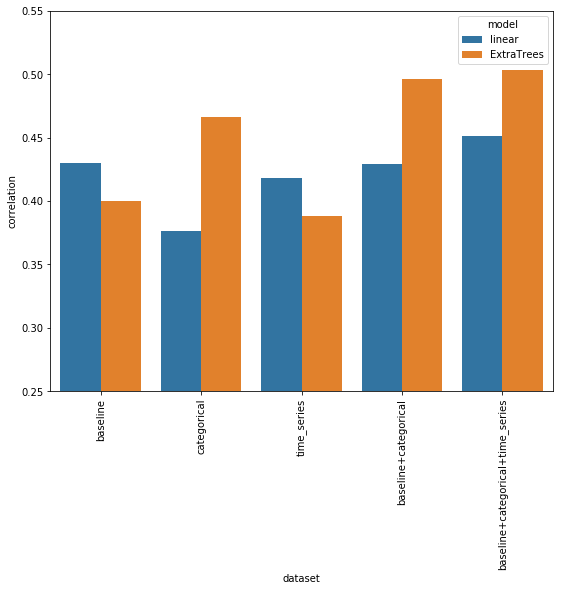

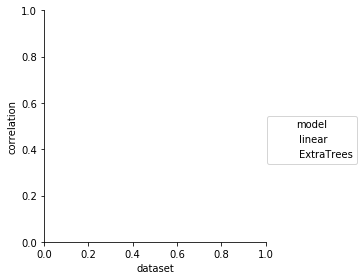

In [135]:
fig, ax = plt.subplots(figsize=(9,7))
plt.xticks(rotation=90)
sns.factorplot(x='dataset', y='correlation', hue='model', 
               data=pd.DataFrame(results, columns=['dataset', 'model', 'correlation', 'top10']), kind='bar',
              ax=ax)
ax.set_ylim(0.25,0.55)


In [139]:
from datetime import date

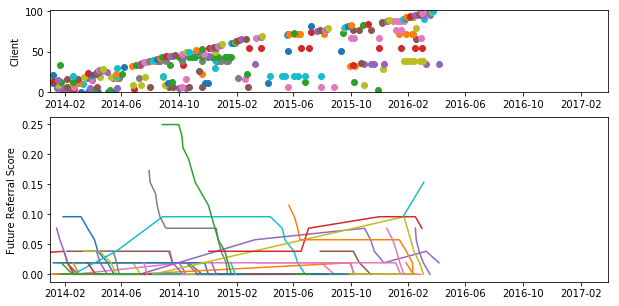

In [160]:
def plot_time_series_with_scores(referrals, client_ids_to_plot):
    for_plot = referrals[(referrals['ClientId'].isin(client_ids_to_plot))]
    fig = plt.figure(figsize=(10, 5))
    gs = plt.GridSpec(2, 1, height_ratios=[1, 2]) 
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])
    i = 1
    for k,g in for_plot.groupby('ClientId'):
        g = g.sort_values('ReferralTakenDate')
        ax0.plot_date(x=g['ReferralTakenDate'], y=[i for j in range(len(g))])
        ax1.plot_date(x=g['ReferralTakenDate'], y=g['future_referral_score'],
                     linestyle='solid', marker='None')
        i += 1
    ax0.set_xlim(date(2014,1,1), date(2017,4,1))
    ax1.set_xlim(date(2014,1,1), date(2017,4,1))
    ax0.set_ylabel('Client')
    ax0.set_ylim(0, len(client_ids_to_plot) + 1)
    ax1.set_ylabel('Future Referral Score')
    
plot_time_series_with_scores(referrals, referrals.groupby('ClientId').size().sample(100).index)

# Baseline

In [ ]:
X_train = referrals[['referral_no']].loc[y_train.index]
X_test = referrals[['referral_no']].loc[y_test.index]

In [ ]:
# Fit Logistic Regression
param_grid = {
    'reg__alpha': np.logspace(-5,5,11)
}
gs = GridSearchCV(pipe, param_grid, cv=10, scoring='neg_mean_absolute_error', verbose=3)
gs.fit(X_train, y_train)

In [ ]:
np.corrcoef(gs.predict(X_test), y_test)


# Referral/Client Features

In [ ]:
X_train = client_and_referral_features.loc[y_train.index]
X_test = client_and_referral_features.loc[y_test.index]

In [ ]:
from scipy.sparse import csr_matrix

In [ ]:
csr_matrix((X_train*1).astype(int))

In [ ]:
# Fit Logistic Regression
param_grid = {
    'reg__alpha': np.logspace(-5,5,11)
}
gs = GridSearchCV(pipe, param_grid, cv=10, scoring='neg_mean_absolute_error', verbose=3)
gs.fit(X_train, y_train)

In [ ]:
np.corrcoef(gs.predict(X_test), y_test)


# Window Features

In [ ]:
X_train = ewm_features.loc[y_train.index]
X_test = ewm_features.loc[y_test.index]

In [ ]:
# Create Model Pipeline
from sklearn.preprocessing import PolynomialFeatures
pipe = Pipeline([
    ('imp', Imputer()),
    ('scale', StandardScaler()),
#     ('poly', PolynomialFeatures(2)),
    ('reg', Ridge())
])

In [ ]:
# Fit Logistic Regression
param_grid = {
    'reg__alpha': np.logspace(-5,5,11)
}
gs = GridSearchCV(pipe, param_grid, cv=10, scoring='neg_mean_squared_error', verbose=3)
gs.fit(X_train, y_train)

In [ ]:
np.corrcoef(gs.predict(X_test), y_test)


# All Features

In [ ]:
X = pd.concat([ewm_features, client_and_referral_features, referrals[['referral_no']]], axis=1)
X_train = X.loc[y_train.index]
X_test = X.loc[y_test.index]

In [ ]:
# Fit Logistic Regression
param_grid = {
    'reg__alpha': np.logspace(-5,5,11)
}
gs = GridSearchCV(pipe, param_grid, cv=10, scoring='neg_mean_absolute_error', verbose=3)
gs.fit(X_train, y_train)

In [ ]:
np.corrcoef(gs.predict(X_test), y_test)

In [ ]:
spearmanr(gs.predict(X_test), y_test)


In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.scatter(y_test, gs.predict(X_test))

# Metric Adjustment

Add sample weighting and do time slice evaluation

In [ ]:
from sklearn.base import BaseEstimator, RegressorMixin

class SegmentedRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, base_cls, splitters, split_on):
        self.base_cls = base_cls
        self.splitters = [-np.inf] + splitters + [np.inf]
        self.split_on = split_on
        self.models = {}

    def fit(self, X, y, **fit_params):
        sample_weight = fit_params['sample_weight']
        split_categories = pd.cut(X[self.split_on], self.splitters)
        groups = X.groupby(split_categories).groups
        for ind in groups:
            self.models[ind] = self.base_cls()
            self.models[ind].fit(X.loc[groups[ind]], y.loc[groups[ind]], 
                                 sample_weight=sample_weight.loc[groups[ind]])
    
    def predict(self, X):
        split_categories = pd.cut(X[self.split_on], self.splitters)
        y_pred = pd.Series(index=X.index)
        groups = X.groupby(split_categories).groups
        for ind in groups:
            pred = self.models[ind].predict(X.loc[groups[ind]])            
            y_pred.loc[groups[ind]] = pred
            
        return y_pred

In [ ]:
X = pd.concat([ewm_features, client_and_referral_features, referrals['referral_no']], axis=1)
X_train = X.loc[y_train.index]
X_test = X.loc[y_test.index]

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor
et = ExtraTreesRegressor(1000, n_jobs=-1)
et.fit(X_train, y_train, sample_weight=sample_weight)

In [ ]:
pred = pd.Series(et.predict(X_test), y_test.index)

In [ ]:
from sklearn.linear_model import RidgeCV
seg = SegmentedRegressor(RidgeCV, list(range(1,32)), 'referral_no')
seg.fit(X_train, y_train, sample_weight=sample_weight)


In [ ]:
pred = seg.predict(X_test)

In [ ]:
train_ref = referrals.loc[X_train.index]
sample_weight = 1 / train_ref.groupby('ClientId').size().loc[train_ref['ClientId']]
sample_weight.index = train_ref.index

In [ ]:
# Fit Logistic Regression
param_grid = {
    'reg__alpha': np.logspace(-5,5,11)
}
gs = GridSearchCV(pipe, param_grid, cv=3, scoring='neg_mean_absolute_error', verbose=3)
gs.fit(X_train, y_train, reg__sample_weight=sample_weight)

In [ ]:
pred = pd.Series(gs.predict(X_test), index=X_test.index)
test_ref = referrals.loc[X_test.index]

In [ ]:
t_counts = test_ref.groupby('ClientId')['referral_no'].max()

In [ ]:
def get_scores(x, y, threshold=0.10):
    corr = spearmanr(x, y)[0]
    mu_a_top = mu_a[mu_a.rank(ascending=False) / len(mu_a) < threshold]
    mu_p_top = mu_p[mu_p.rank(ascending=False) / len(mu_p) < threshold]
    overlap = mu_p_top.index.isin(mu_a_top.index).mean()
    return pd.Series([corr, overlap])

In [ ]:
time_grouped = test_ref.assign(y=y_test).assign(pred=pred).set_index('ReferralTakenDate').groupby([pd.TimeGrouper('1W'), 'ClientId'])[['y', 'pred']].mean()
time_grouped.reset_index().groupby(['ReferralTakenDate']).apply(lambda k: get_scores(k['y'], k['pred'])).dropna().mean()

In [ ]:
time_grouped = test_ref.assign(y=y_test).assign(pred=pred).set_index('ReferralTakenDate').groupby([pd.TimeGrouper('1W'), 'ClientId'])[['y', 'pred']].mean()
time_grouped.reset_index().groupby(['ReferralTakenDate']).apply(lambda k: get_scores(k['y'], k['pred'])).dropna().mean()

In [ ]:
time_grouped = test_ref.assign(y=y_test).assign(pred=pred).set_index('ReferralTakenDate').groupby([pd.TimeGrouper('1W'), 'ClientId'])[['y', 'pred']].mean()
time_grouped.reset_index().groupby(['ReferralTakenDate']).apply(lambda k: get_scores(k['y'], k['pred'])).dropna().mean()

In [ ]:
time_grouped = test_ref.assign(y=y_test).assign(pred=pred).set_index('ReferralTakenDate').groupby([pd.TimeGrouper('1W'), 'ClientId'])[['y', 'pred']].mean()
time_grouped.reset_index().groupby(['ReferralTakenDate']).apply(lambda k: get_scores(k['y'], k['pred'])).dropna().mean()

In [ ]:
time_grouped = test_ref.assign(y=y_test).assign(pred=pred).set_index('ReferralTakenDate').groupby([pd.TimeGrouper('1W'), 'ClientId'])[['y', 'pred']].mean()
time_grouped.reset_index().groupby(['ReferralTakenDate']).apply(lambda k: get_scores(k['y'], k['pred'])).dropna().mean()

In [ ]:
time_grouped = test_ref.assign(y=y_test).assign(pred=pred).set_index('ReferralTakenDate').groupby([pd.TimeGrouper('1W'), 'ClientId'])[['y', 'pred']].mean()
time_grouped.reset_index().groupby(['ReferralTakenDate']).apply(lambda k: get_scores(k['y'], k['pred'])).dropna().mean()

In [ ]:
mu_a = y_test.groupby(test_ref['ClientId']).mean()
mu_p = pred.groupby(test_ref['ClientId']).mean()

In [ ]:
spearmanr(mu_a, mu_p)

In [ ]:
spearmanr(mu_a, mu_p)

In [ ]:
res = {}
for i in range(2,15):
    res[i] = spearmanr(mu_a[t_counts<i], mu_p[t_counts<i])[0]

pd.Series(res).plot()
    

In [ ]:
res = {}
for i in range(2,15):
    res[i] = spearmanr(mu_a[t_counts<i], mu_p[t_counts<i])[0]

pd.Series(res).plot()
    

In [ ]:
res = {}
for i in range(1,12):
    mu_a_top = mu_a[mu_a.rank(ascending=False) / len(mu_a) < i / 20]
    mu_p_top = mu_p[mu_p.rank(ascending=False) / len(mu_p) < i / 20]
    res[i/10] = mu_p_top.index.isin(mu_a_top.index).mean()

In [ ]:
plt.scatter(mu_a, mu_p, alpha=0.1)

In [ ]:
pd.Series(res).plot()

In [ ]:
mu_p_top.index.isin(mu_a_top.index).mean()

In [ ]:
spearmanr(mu_a.values, mu_p.values)

In [ ]:
# loop over each referral and check 'valid predictions' within the last 12 months. 
# What is the rank correlation within that set?
tup_list = []
for index, row in tqdm_notebook(test_ref.iterrows()):
    referrals_in_period = test_ref[(test_ref['ReferralTakenDate'] > (row['ReferralTakenDate'] - pd.Timedelta(365, 'd')))
                                & (test_ref['ReferralTakenDate'] <= row['ReferralTakenDate'])]
    latest = referrals_in_period.reset_index().groupby('ClientId').last()
    client_pred, client_score = pred.loc[latest['index']], y_test.loc[latest['index']]
    actual_top = client_score[client_score.rank(ascending=False) / len(client_score) < 0.1]
    pred_top = client_pred[client_pred.rank(ascending=False) / len(client_pred) < 0.1]
    top_10 = pred_top.index.isin(actual_top.index).mean()
    
    corr = spearmanr(pred.loc[latest['index']], y_test.loc[latest['index']])
    tup_list.append([index, len(latest), corr[0], corr[1], top_10])
    


In [ ]:
pd.DataFrame(tup_list, columns=['index', 'n_clients', 'corr', 'p_value', 'overlap']).iloc[:1000]

In [ ]:
pd.DataFrame(tup_list, columns=['index', 'n_clients', 'corr', 'p_value', 'overlap']).dropna()[['corr', 'overlap']].plot()

In [ ]:
pd.DataFrame(tup_list, columns=['index', 'n_clients', 'corr', 'p_value', 'overlap']).dropna()[['corr', 'overlap']].plot()